# Notebook - Baseline Models

## Import Modules

In [1]:
import omegaconf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import json
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from tqdm import tqdm
from sklearn import metrics
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# === Load configuration file
config_path = "../config/config.yaml"
config = omegaconf.OmegaConf.load(config_path)
trained_model_folder_no = config.evaluation.folder_no
split_ratio = 0.6

## Load Dataset

In [3]:
# Import dataset
dataset = pd.read_parquet("../trained_model/Train-Result-"+ str(trained_model_folder_no)+ "/feature_dataset.parquet")

# get x and y
x = dataset[['fuel_load_cwdc', 'fuel_load_deadcrootc', 'fuel_wetness', 'fuel_temperature', 'climate_wind',
             'climate_tbot', 'climate_rh2m', 'climate_rain', 'human_density', 'light_frequency','burned_area_mom','burned_area_yoy','month','lat']]
y = dataset["burned_area"]
# convert to numpy
x = np.array(x)
y = np.array(y).reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
x_stand = scaler_X.fit_transform(x)
y_stand = scaler_y.fit_transform(y)
train_x = x_stand[0:int(split_ratio*len(x_stand)),:]
train_y = y_stand[0:int(split_ratio*len(y_stand)),:]
test_x = x_stand[int(split_ratio*len(x_stand)):x_stand.shape[0],:]
test_y = y_stand[int(split_ratio*len(y_stand)):y_stand.shape[0],:]


# get x and y
x_indic = dataset[["lat","lon","month","sequence"]]
x_indic = np.array(x_indic)
# prepare data
val_x = x_stand
val_y = y_stand
lat_indicator = x_indic[:,0]
lon_indicator = x_indic[:,1]
month_indicator = x_indic[:,2]
year_indicator = x_indic[:,3]

print(x_stand.shape)

(96271, 14)


In [4]:
# Import JSON file
region_dict_path = "../raw_dataset/region_segmentation.json"
with open(region_dict_path,'r', encoding='UTF-8') as f:
    region_dict = json.load(f)

### Function - Visualization

In [5]:
def prediction_producer(regressor, model_type, model_name):
    # create lists
    month_list = []
    y_true_list = []
    y_pred_list = []
    region_list = []
    year_list = []
    if model_type == "sklearn":
        y_pred_list = regressor.predict(val_x).tolist()
        month_list = dataset["month"].tolist()
        y_true_list = val_y.tolist()
        year_list = [year_indicator[i] for i in range(val_x.shape[0])]
        region_list = [[lat_indicator[i],lon_indicator[i]] for i in range(val_x.shape[0])]

    
    # Lambda Function to substitute Lat and Lon with Region names
    def region_labeler(x):
        for region_name in region_dict.keys():
            if x in region_dict[region_name]:
                return region_name
    
    # month_dict_convertor
    month_dict = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
    # Lambda Function to substitute years seq to years 
    year_dict_temp = list(set(year_list))
    year_dict= {}
    sep_lst = []
    start_year = 2001
    for i,v in enumerate(year_dict_temp):
        if (i+1) % 12 != 0:
            sep_lst.append(v)
        else:
            sep_lst.append(v)
            year_dict[start_year] = sep_lst
            sep_lst = []
            start_year += 1
    def year_labeler(x):
        for yrs in year_dict.keys():
            if x in year_dict[yrs]:
                return yrs
    # Reverse Standization
    true_log_value = scaler_y.inverse_transform(np.array(y_true_list).reshape(-1,1))
    pred_log_value = scaler_y.inverse_transform(np.array(y_pred_list).reshape(-1,1))
    
    evaluator = pd.DataFrame(columns=["y_true","y_pred","month","region","year"])
    # model predictions
    evaluator["y_true"] = y_true_list
    evaluator["y_pred"] = y_pred_list
    # inverse standardization
    evaluator["y_true_transform_log"] = true_log_value
    evaluator["y_pred_transform_log"] = pred_log_value
    
    evaluator["y_true_transform_origin"] = np.exp(evaluator["y_true_transform_log"])
    evaluator["y_pred_transform_origin"] = np.exp(evaluator["y_pred_transform_log"])
    
    # month labeling
    evaluator["month"] = month_list
    evaluator["month_label"] = evaluator["month"].apply(lambda x: month_dict[x])
    # year labeling
    evaluator["year"] = year_list
    evaluator["year_label"] = evaluator["year"].apply(lambda x: year_labeler(x))
    # region labeling
    evaluator["region"] = region_list
    evaluator["region_label"] = evaluator["region"].apply(lambda x: region_labeler(x))
    # drop na values
    evaluator.dropna(inplace=True)
    # evaluation by years
    evaluation_year = evaluator.copy()
    evaluation_year = evaluation_year[['y_true', 'y_pred','y_true_transform_log',
                                       'y_pred_transform_log', 'y_true_transform_origin',
                                       'y_pred_transform_origin', 'year_label']]
    group_data = pd.DataFrame(evaluation_year.groupby(by="year_label").sum())
    plt.plot(group_data["y_true_transform_log"], label = "Burned Area (Log scale)")
    plt.plot(group_data["y_pred_transform_log"], label = "Pred Area (Log scale)")
    plt.fill_between(group_data.index, group_data["y_true_transform_log"].tolist(), group_data["y_pred_transform_log"].tolist(), alpha=.5, linewidth=0)
    plt.title("Performance Evaluation by Year - Ln(BA)",fontsize = 11)
    plt.legend(loc = "upper left",fontsize = 10)
    plt.show()
    
    # evaluation by months
    evaluation_month = evaluator.copy()
    del evaluation_month["region"]
    group_data = pd.DataFrame(evaluation_month.groupby(by="month").sum()).sort_values(by="month")
    group_data["month_label"] = group_data.index
    group_data["month_label"] = group_data["month_label"].apply(lambda x: month_dict[x])
    group_data.set_index("month_label",inplace=True,drop=True)
    plt.plot(group_data["y_true_transform_log"], label = "Burned Area (Log scale)")
    plt.plot(group_data["y_pred_transform_log"], label = "Pred Area (Log scale)")
    plt.fill_between(group_data.index, group_data["y_true_transform_log"].tolist(), group_data["y_pred_transform_log"].tolist(), alpha=.5, linewidth=0)
    plt.title("Performance Evaluation by Month - Ln(BA)",fontsize = 11)
    plt.legend(loc = "upper left",fontsize = 10)
    plt.show()
    
    evaluator_output = evaluator[["y_true_transform_log","y_pred_transform_log","month","region"]]
    
    return evaluator_output


### Baseline Model - Linear Regression

-> Accuracy Score (R-sqaured):  0.6763087304441147


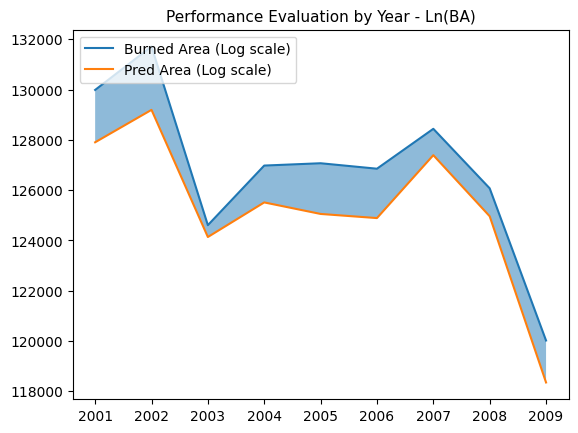

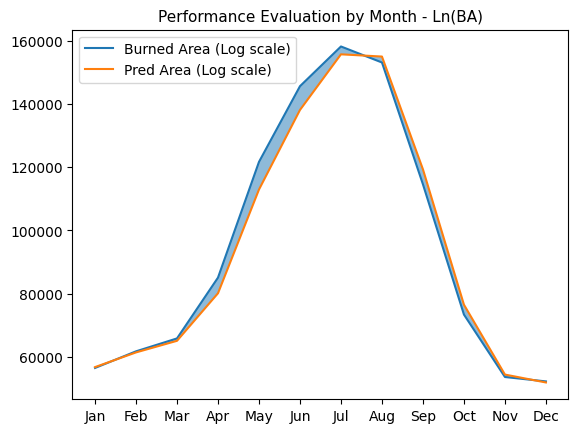

In [6]:
reg_lr = LinearRegression().fit(train_x, train_y)
print("-> Accuracy Score (R-sqaured): ", reg_lr.score(test_x, test_y, sample_weight=None))
lr_evaluation = prediction_producer(reg_lr, "sklearn", "LR-Fire")

### Baseline Model - Lasso Regression

-> Accuracy Score (R-sqaured):  0.6545030751265246


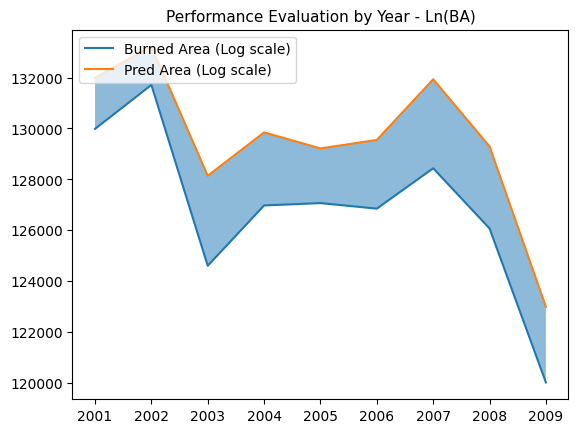

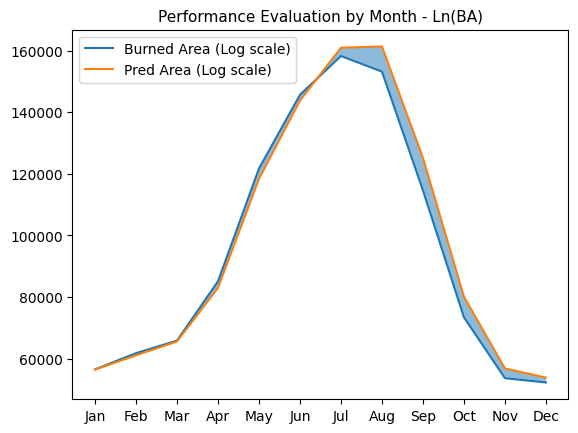

In [7]:
reg_la = Lasso(alpha=0.1).fit(train_x, train_y)
print("-> Accuracy Score (R-sqaured): ", reg_la.score(test_x, test_y, sample_weight=None))
Lasso_evaluation = prediction_producer(reg_la, "sklearn", "Lasso-Fire")

### Baseline Model - Ridge Regression

-> Accuracy Score (R-sqaured):  0.6763494128607632


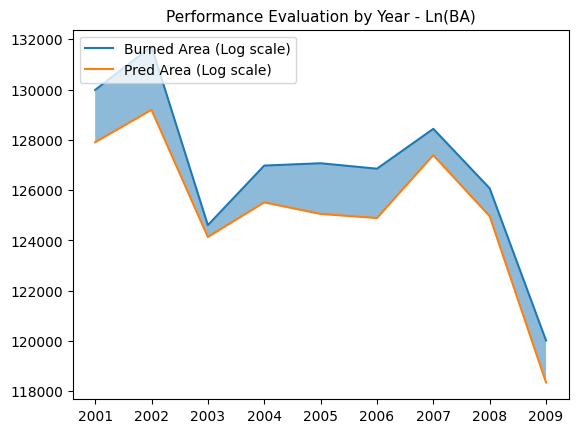

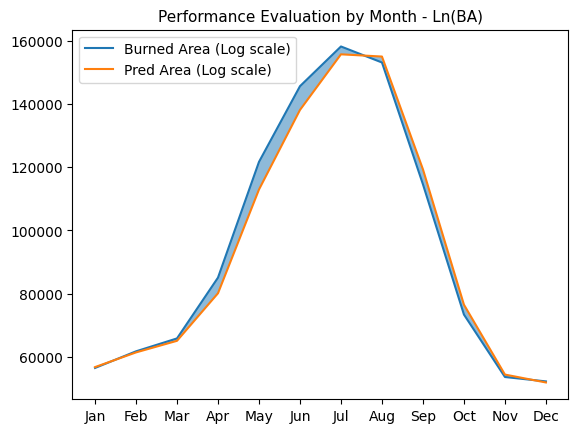

In [8]:
reg_rd = Ridge(alpha=1.0).fit(train_x, train_y)
print("-> Accuracy Score (R-sqaured): ", reg_rd.score(test_x, test_y, sample_weight=None))
Ridge_evaluation = prediction_producer(reg_rd, "sklearn", "Ridge-Fire")

### Baseline Model - Decision Tree Regression

-> Accuracy Score (R-sqaured):  0.24274285522936867


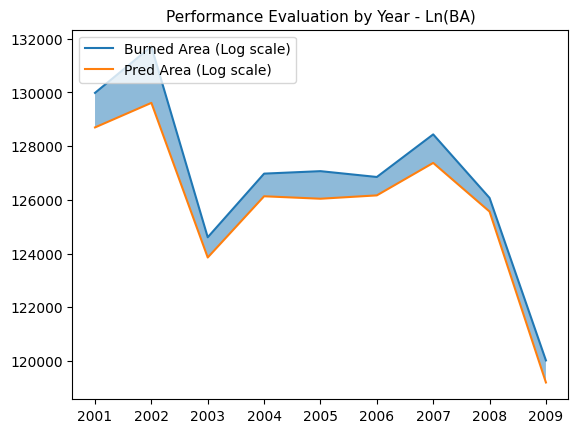

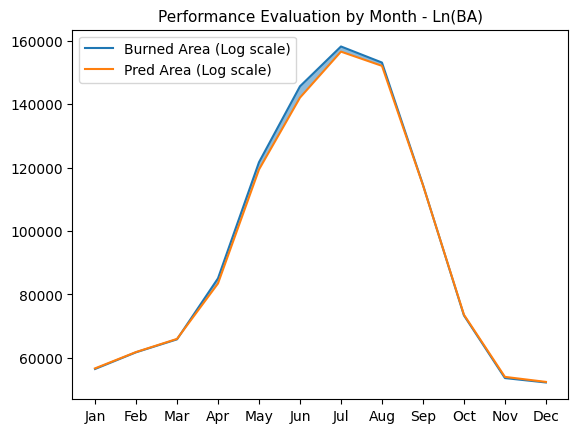

In [9]:
reg_dt = DecisionTreeRegressor().fit(train_x, train_y)
print("-> Accuracy Score (R-sqaured): ", reg_dt.score(test_x, test_y, sample_weight=None))
DTR_evaluation = prediction_producer(reg_dt, "sklearn", "DT-Fire")

### Baseline Model - K-Neighbor Regression

-> Accuracy Score (R-sqaured):  0.5992310819032609


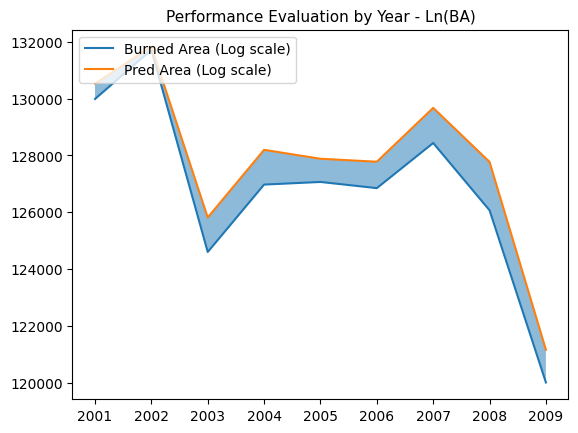

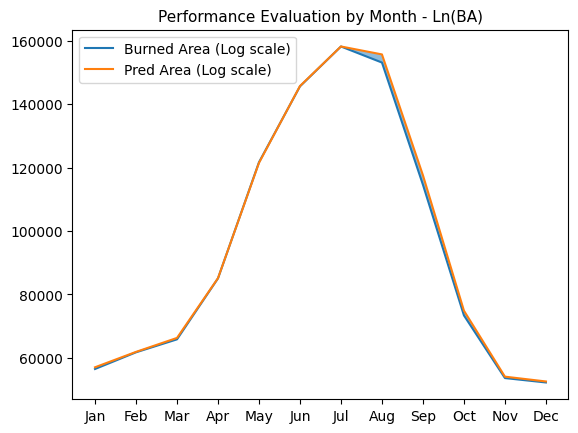

In [10]:
reg_kn = KNeighborsRegressor().fit(train_x, train_y)
print("-> Accuracy Score (R-sqaured): ", reg_kn.score(test_x, test_y, sample_weight=None))
KN_evaluation = prediction_producer(reg_kn, "sklearn", "KN-Fire")

### Baseline - Deep Neural Networks

In [11]:
# set seed
torch.cuda.manual_seed(1)
# Switch to GPU for Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Clear GPU caches
torch.cuda.empty_cache()
# print(torch.cuda.memory_summary())
batch_size = 20000 # 20000
split_ratio = 0.6
learning_rate = 0.00015
epochs = 250

In [12]:
# import dataset
dataset = pd.read_parquet("../trained_model/Train-Result-"+ str(trained_model_folder_no)+ "/feature_dataset.parquet")
# get x and y
x = dataset[['fuel_load_cwdc', 'fuel_load_deadcrootc', 'fuel_wetness', 'fuel_temperature', 'climate_wind', 'climate_tbot', 'climate_rh2m', 'climate_rain', 'human_density', 'light_frequency',"burned_area_mom","burned_area_yoy","lat","month"]]
y = dataset["burned_area"]
# convert to numpy
x = np.array(x)
y = np.array(y).reshape(-1, 1)

In [13]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
x_stand = scaler_X.fit_transform(x)
y_stand = scaler_y.fit_transform(y)

In [14]:
train_x = x_stand[0:int(split_ratio*len(x_stand)),:]
train_y = y_stand[0:int(split_ratio*len(y_stand)),:]
test_x = x_stand[int(split_ratio*len(x_stand)):x_stand.shape[0],:]
test_y = y_stand[int(split_ratio*len(y_stand)):y_stand.shape[0],:]

In [15]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_inputs, data_targets):
        self.inputs = torch.tensor(data_inputs).float()
        self.label = torch.tensor(data_targets).float()

    def __getitem__(self, idx):
        x = self.inputs[idx]
        y = self.label[idx]
        return x, y

    def __len__(self):
        return len(self.label)

In [16]:
trainset = Dataset(train_x, train_y)
testset = Dataset(test_x, test_y)
TrainDataLoader = Data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=False)
TestDataLoader = Data.DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last=False)

In [17]:
for i,(v,j) in enumerate(TrainDataLoader):
    print(v.shape,j.shape)
    break

torch.Size([20000, 14]) torch.Size([20000, 1])


In [18]:
# Define the neural network
class network(nn.Module):
    def __init__(self):
        super(network, self).__init__()
        self.layer1 = nn.Linear(train_x.shape[1], train_x.shape[1]*2)
        self.layer2 = nn.Linear(train_x.shape[1]*2, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 4)
        self.layer5 = nn.Linear(4, 1)
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer4(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.layer5(x)

        return x

In [19]:
net = network().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
net

network(
  (layer1): Linear(in_features=14, out_features=28, bias=True)
  (layer2): Linear(in_features=28, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=4, bias=True)
  (layer5): Linear(in_features=4, out_features=1, bias=True)
  (activation): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [20]:
# metrics lists
train_loss_history = []
train_r2_history = []
val_loss_history = []
val_r2_history = []
val_rho_history = []

In [21]:
# Perform iterations
for epoch in tqdm(range(epochs), desc='Training'):
    # create lists
    train_loss_lst = []
    train_r2_lst = []
    val_loss_lst = []
    val_r2_lst = []
    val_rho_lst = []


    # ====== Training Mode ======
    net.train()
    for (x_input, y_true) in TrainDataLoader:
        # attach to GPU
        x_input = x_input.to(device)
        y_true = y_true.to(device)
        # gain outputs
        outputs = net(x_input)
        # compute loss
        loss = criterion(outputs, y_true)
        # Back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # r2 = r_squared(y_true, outputs)
        r2 = metrics.r2_score(y_true.detach().cpu().numpy().squeeze(),outputs.detach().cpu().numpy().squeeze())
        # append results
        train_loss_lst.append(loss.item())
        train_r2_lst.append(r2)
    # Append the performance result after each epoch
    best_perform = train_r2_lst.index(max(train_r2_lst))
    train_loss_history.append(train_loss_lst[best_perform])
    train_r2_history.append(train_r2_lst[best_perform])
    # ====== Training Mode End ======


    # ====== Testing Mode ======
    net.eval()
    for (x_val_input, y_val_input) in TestDataLoader:
        # attach to GPU
        x_val_input = x_val_input.to(device)
        y_val_input = y_val_input.to(device)
        # gain outputs
        outputs = net(x_val_input)
        # compute loss
        loss = criterion(outputs, y_val_input)
        # r2 = r_squared(y_val_input, outputs) & Rho
        r2 = metrics.r2_score(y_val_input.detach().cpu().numpy().squeeze(),outputs.detach().cpu().numpy().squeeze())
        rho = np.corrcoef(y_val_input.detach().cpu().numpy().squeeze(), outputs.detach().cpu().numpy().squeeze())[0][1]
        # append results
        val_rho_lst.append(rho)
        val_loss_lst.append(loss.item())
        val_r2_lst.append(r2)
    # Append the performance result after each epoch
    best_perform = val_r2_lst.index(max(val_r2_lst))
    val_loss_history.append(val_loss_lst[best_perform])
    val_r2_history.append(val_r2_lst[best_perform])
    val_rho_history.append(val_rho_lst[best_perform])
    # ====== Testing Mode End ======


    # output the performance every 10 times
    # if str(epoch+1).endswith("0"):
print("Final Epoch: "+str(epoch+1)+"/"+str(epochs), " | Train Loss: "+str(train_loss_history[-1]), " | Train R2: "+str(train_r2_history[-1])," | Val Loss: "+str(val_loss_history[-1])," | Val Rho: "+str(val_rho_history[-1])," | Val R2: "+str(val_r2_history[-1]))

Training: 100%|██████████| 250/250 [03:26<00:00,  1.21it/s]

Final Epoch: 250/250  | Train Loss: 0.3243679106235504  | Train R2: 0.6898914930739662  | Val Loss: 0.17637133598327637  | Val Rho: 0.8403250018721308  | Val R2: 0.6880428607787126


In [22]:
# Save Model Path
# path = ("../trained_model/Train-Result-"+ str(trained_model_folder_no)+ "/dnn_baseline_trained_model.pth")
# torch.save(net.state_dict(),path)
evaluation = pd.DataFrame(columns = ["train loss","train accuracy","validation loss","validation accuracy","validation Rho"])
evaluation["train loss"] =train_loss_history
evaluation["train accuracy"] =train_r2_history
evaluation["validation loss"] =val_loss_history
evaluation["validation accuracy"] = val_r2_history
evaluation["validation Rho"] = val_rho_history

In [23]:
# get x and y
x_indic = dataset[["lat","lon","month","sequence"]]

x = dataset[['fuel_load_cwdc', 'fuel_load_deadcrootc', 'fuel_wetness', 'fuel_temperature', 'climate_wind', 'climate_tbot', 'climate_rh2m', 'climate_rain', 'human_density', 'light_frequency',"burned_area_mom","burned_area_yoy","lat","month"]]
y = dataset["burned_area"]
# convert to numpy
x_indic = np.array(x_indic)
x = np.array(x)
y = np.array(y).reshape(-1, 1)

In [24]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
x_stand = scaler_X.fit_transform(x)
y_stand = scaler_y.fit_transform(y)

In [25]:
train_x = x_stand[0:int(split_ratio*len(x_stand)),:]
train_y = y_stand[0:int(split_ratio*len(y_stand)),:]
test_x = x_stand[int(split_ratio*len(x_stand)):x_stand.shape[0],:]
test_y = y_stand[int(split_ratio*len(y_stand)):y_stand.shape[0],:]

In [26]:
trainset = Dataset(train_x, train_y)
testset = Dataset(test_x, test_y)
TrainDataLoader = Data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=False)
TestDataLoader = Data.DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last=False)

In [27]:
# prepare data
val_x = torch.tensor(x_stand).float()
val_y = torch.tensor(y_stand).float()
lat_indicator = x_indic[:,0]
lon_indicator = x_indic[:,1]
month_indicator = x_indic[:,2]
year_indicator = x_indic[:,3]

# create lists
month_list = []
y_true_list = []
y_pred_list = []
region_list = []
year_list = []

# validation mode
net.eval()
for idx in tqdm(range(val_x.shape[0])):
    month_list.append(month_indicator[idx])
    region_list.append([lat_indicator[idx],lon_indicator[idx]])
    year_list.append(year_indicator[idx])
    x_input = val_x[idx,:].to(device)
    y_input = val_y[idx,-1].to(device).detach().cpu().numpy().squeeze()
    y_true_list.append(y_input)
    y_pred = net(x_input)
    y_pred = y_pred.detach().cpu().numpy().squeeze()
    y_pred_list.append(y_pred)

100%|██████████| 96271/96271 [01:26<00:00, 1114.24it/s]


In [28]:
# Lambda Function to substitute Lat and Lon with Region names
def region_labeler(x):
    for region_name in region_dict.keys():
        if x in region_dict[region_name]:
            return region_name

# month_dict_convertor
month_dict = {1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}
# Lambda Function to substitute years seq to years 
year_dict_temp = list(set(year_list))
year_dict= {}
sep_lst = []
start_year = 2001
for i,v in enumerate(year_dict_temp):
    if (i+1) % 12 != 0:
        sep_lst.append(v)
    else:
        sep_lst.append(v)
        year_dict[start_year] = sep_lst
        sep_lst = []
        start_year += 1
def year_labeler(x):
    for yrs in year_dict.keys():
        if x in year_dict[yrs]:
            return yrs

In [29]:
# Reverse Standization
true_log_value = scaler_y.inverse_transform(np.array(y_true_list).reshape(-1,1))
pred_log_value = scaler_y.inverse_transform(np.array(y_pred_list).reshape(-1,1))

evaluator = pd.DataFrame(columns=["y_true","y_pred","month","region","year"])
# model predictions
evaluator["y_true"] = y_true_list
evaluator["y_pred"] = y_pred_list
# inverse standardization
evaluator["y_true_transform_log"] = true_log_value
evaluator["y_pred_transform_log"] = pred_log_value

evaluator["y_true_transform_origin"] = np.exp(evaluator["y_true_transform_log"])
evaluator["y_pred_transform_origin"] = np.exp(evaluator["y_pred_transform_log"])

# month labeling
evaluator["month"] = month_list
evaluator["month_label"] = evaluator["month"].apply(lambda x: month_dict[x])
# year labeling
evaluator["year"] = year_list
evaluator["year_label"] = evaluator["year"].apply(lambda x: year_labeler(x))
# region labeling
evaluator["region"] = region_list
evaluator["region_label"] = evaluator["region"].apply(lambda x: region_labeler(x))
# drop na values
evaluator.dropna(inplace=True)

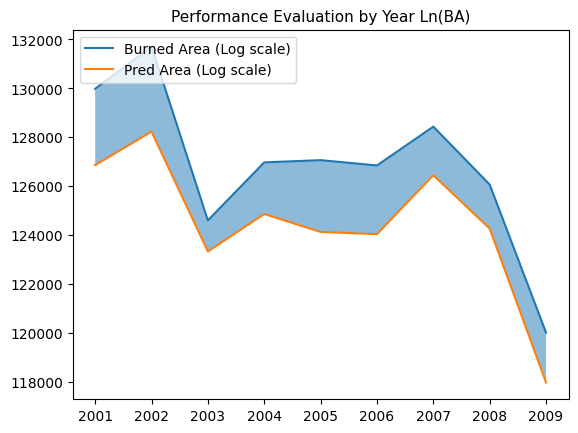

In [30]:
evaluation_year = evaluator.copy()
evaluation_year = evaluation_year[['y_true', 'y_pred', 'y_true_transform_log',
                                   'y_pred_transform_log', 'y_true_transform_origin',
                                   'y_pred_transform_origin', 'year_label']]
group_data = pd.DataFrame(evaluation_year.groupby(by="year_label").sum())
plt.plot(group_data["y_true_transform_log"], label="Burned Area (Log scale)")
plt.plot(group_data["y_pred_transform_log"], label="Pred Area (Log scale)")
plt.fill_between(group_data.index, group_data["y_true_transform_log"].tolist(),
                 group_data["y_pred_transform_log"].tolist(), alpha=.5, linewidth=0)
plt.title("Performance Evaluation by Year Ln(BA)", fontsize=11)
plt.legend(loc="upper left", fontsize=10)
plt.show()

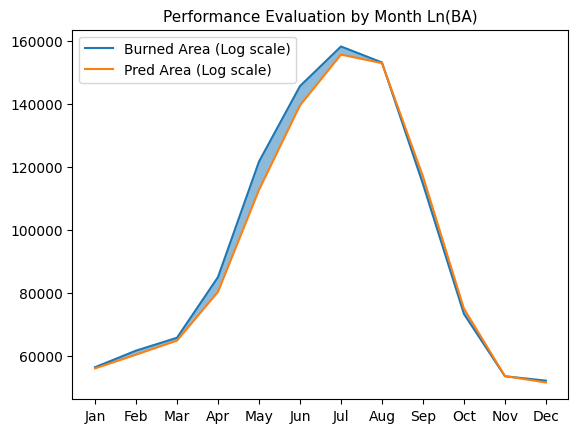

In [31]:
evaluation_month = evaluator.copy()
del evaluation_month["region"]
group_data = pd.DataFrame(evaluation_month.groupby(by="month").sum()).sort_values(by="month")
group_data["month_label"] = group_data.index
group_data["month_label"] = group_data["month_label"].apply(lambda x: month_dict[x])
group_data.set_index("month_label", inplace=True, drop=True)
plt.plot(group_data["y_true_transform_log"], label="Burned Area (Log scale)")
plt.plot(group_data["y_pred_transform_log"], label="Pred Area (Log scale)")
plt.fill_between(group_data.index, group_data["y_true_transform_log"].tolist(),
                 group_data["y_pred_transform_log"].tolist(), alpha=.5, linewidth=0)
plt.title("Performance Evaluation by Month Ln(BA)", fontsize=11)
plt.legend(loc="upper left", fontsize=10)
plt.show()

dnn_evaluation = evaluator[["y_true_transform_log","y_pred_transform_log","month","region"]]

### Save Baseline Model to corresponding folder

In [32]:
lr_evaluation.to_parquet("../trained_model/Train-Result-"+ str(trained_model_folder_no)+ "/baseline_evaluation_lr.parquet")
Lasso_evaluation.to_parquet("../trained_model/Train-Result-"+ str(trained_model_folder_no)+ "/baseline_evaluation_lasso.parquet")
Ridge_evaluation.to_parquet("../trained_model/Train-Result-"+ str(trained_model_folder_no)+ "/baseline_evaluation_ridge.parquet")
DTR_evaluation.to_parquet("../trained_model/Train-Result-"+ str(trained_model_folder_no)+ "/baseline_evaluation_dt.parquet")
KN_evaluation.to_parquet("../trained_model/Train-Result-"+ str(trained_model_folder_no)+ "/baseline_evaluation_kn.parquet")
dnn_evaluation.to_parquet("../trained_model/Train-Result-"+ str(trained_model_folder_no)+ "/baseline_evaluation_dnn.parquet")